# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.7 MB/s eta 0:00:00


# Import Libraries

In [ ]:
#Load the required libraries

import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima.utils import ndiffs
import pmdarima as pm


# Import Data

In [ ]:
data_BTC = pd.read_csv("data/bitcoin_bi.csv")
data_ETH = pd.read_csv("data/ethereum1_bi.csv")

In [ ]:
data_BTC.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1686528000,2023-06-12 00:00:00,BTC/USD,25940.0,25946.0,25920.0,25930.0,3.151708,8.172379e+04
1,1686524400,2023-06-11 23:00:00,BTC/USD,25904.0,25948.0,25833.0,25941.0,32.781225,8.503778e+05
2,1686520800,2023-06-11 22:00:00,BTC/USD,26060.0,26083.0,25769.0,25899.0,154.997012,4.014268e+06
3,1686517200,2023-06-11 21:00:00,BTC/USD,26139.0,26152.0,25993.0,26060.0,32.359775,8.432957e+05
4,1686513600,2023-06-11 20:00:00,BTC/USD,26048.0,26209.0,26048.0,26139.0,81.928913,2.141540e+06


In [ ]:
data_ETH.head()

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USD
0,1686528000,2023-06-12 00:00:00,ETH/USD,1753.4,1753.7,1751.3,1751.5,11.968401,20962.654089
1,1686524400,2023-06-11 23:00:00,ETH/USD,1754.8,1756.7,1748.6,1753.4,74.301041,130279.444535
2,1686520800,2023-06-11 22:00:00,ETH/USD,1765.1,1765.4,1742.8,1754.7,185.821385,326060.784470
3,1686517200,2023-06-11 21:00:00,ETH/USD,1771.0,1771.9,1764.2,1764.4,67.607610,119286.866343
4,1686513600,2023-06-11 20:00:00,ETH/USD,1763.6,1777.7,1763.6,1770.8,107.800478,190893.086336


Features description:
- **Date**: Date of the trade
- **Open**: The price at which the stock began
- **High**: Highest price during that trading day
- **Low**: Lowest price during that trading day
- **Close**: The price at which the stock ended
- **Volume**: The total number of shares, contracts, or units of a financial instrument traded

In [ ]:
data_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44491 entries, 0 to 44490
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        44491 non-null  int64  
 1   date        44491 non-null  object 
 2   symbol      44491 non-null  object 
 3   open        44491 non-null  float64
 4   high        44491 non-null  float64
 5   low         44491 non-null  float64
 6   close       44491 non-null  float64
 7   Volume BTC  44491 non-null  float64
 8   Volume USD  44491 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.1+ MB


In [ ]:
data_ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44491 entries, 0 to 44490
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        44491 non-null  int64  
 1   date        44491 non-null  object 
 2   symbol      44491 non-null  object 
 3   open        44491 non-null  float64
 4   high        44491 non-null  float64
 5   low         44491 non-null  float64
 6   close       44491 non-null  float64
 7   Volume ETH  44491 non-null  float64
 8   Volume USD  44491 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.1+ MB


In [ ]:
# Removing columns: We will focus on the Close column, but we keep all OHLC (open, high, low, close) for Candlestick visualization
# The volume can be used later in modelling using feature engineering

data_BTC = data_BTC.drop(columns=['unix', 'symbol', 'Volume BTC', 'Volume USD'])
data_ETH = data_ETH.drop(columns=['unix', 'symbol', 'Volume ETH', 'Volume USD'])

In [ ]:
data_BTC.head()

,date,open,high,low,close
0,2023-06-12 00:00:00,25940.0,25946.0,25920.0,25930.0
1,2023-06-11 23:00:00,25904.0,25948.0,25833.0,25941.0
2,2023-06-11 22:00:00,26060.0,26083.0,25769.0,25899.0
3,2023-06-11 21:00:00,26139.0,26152.0,25993.0,26060.0
4,2023-06-11 20:00:00,26048.0,26209.0,26048.0,26139.0


In [ ]:
data_ETH.head()

,date,open,high,low,close
0,2023-06-12 00:00:00,1753.4,1753.7,1751.3,1751.5
1,2023-06-11 23:00:00,1754.8,1756.7,1748.6,1753.4
2,2023-06-11 22:00:00,1765.1,1765.4,1742.8,1754.7
3,2023-06-11 21:00:00,1771.0,1771.9,1764.2,1764.4
4,2023-06-11 20:00:00,1763.6,1777.7,1763.6,1770.8


# EDA

## Converting to Datetime

In [ ]:
# Converting the Date column from object to datetime
data_BTC[["date"]] = data_BTC[["date"]].apply(pd.to_datetime)
data_ETH[["date"]] = data_ETH[["date"]].apply(pd.to_datetime)

In [ ]:
data_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44491 entries, 0 to 44490
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    44491 non-null  datetime64[ns]
 1   open    44491 non-null  float64       
 2   high    44491 non-null  float64       
 3   low     44491 non-null  float64       
 4   close   44491 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.7 MB


In [ ]:
data_ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44491 entries, 0 to 44490
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    44491 non-null  datetime64[ns]
 1   open    44491 non-null  float64       
 2   high    44491 non-null  float64       
 3   low     44491 non-null  float64       
 4   close   44491 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.7 MB


## Sorting in ascending Date Order

In [ ]:
data_BTC = data_BTC.sort_values(by = "date", ascending = True, ignore_index=True)
data_BTC.head()

,date,open,high,low,close
0,2018-05-15 06:00:00,8733.86,8796.68,8707.28,8740.99
1,2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00
2,2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49
3,2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32
4,2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90


In [ ]:
data_ETH = data_ETH.sort_values(by = "date", ascending = True, ignore_index=True)
data_ETH.head()

,date,open,high,low,close
0,2018-05-15 06:00:00,732.10,736.67,730.94,733.00
1,2018-05-15 07:00:00,733.00,735.99,730.45,733.82
2,2018-05-15 08:00:00,733.82,734.92,721.58,731.68
3,2018-05-15 09:00:00,731.68,731.82,726.98,727.32
4,2018-05-15 10:00:00,727.32,739.37,725.04,733.59


## Missing Data

In [ ]:
# check for missing data
data_BTC.isnull().any()

date     False
open     False
high     False
low      False
close    False
dtype: bool

In [ ]:
data_ETH.isnull().any()

date     False
open     False
high     False
low      False
close    False
dtype: bool

## Hourly Time Series

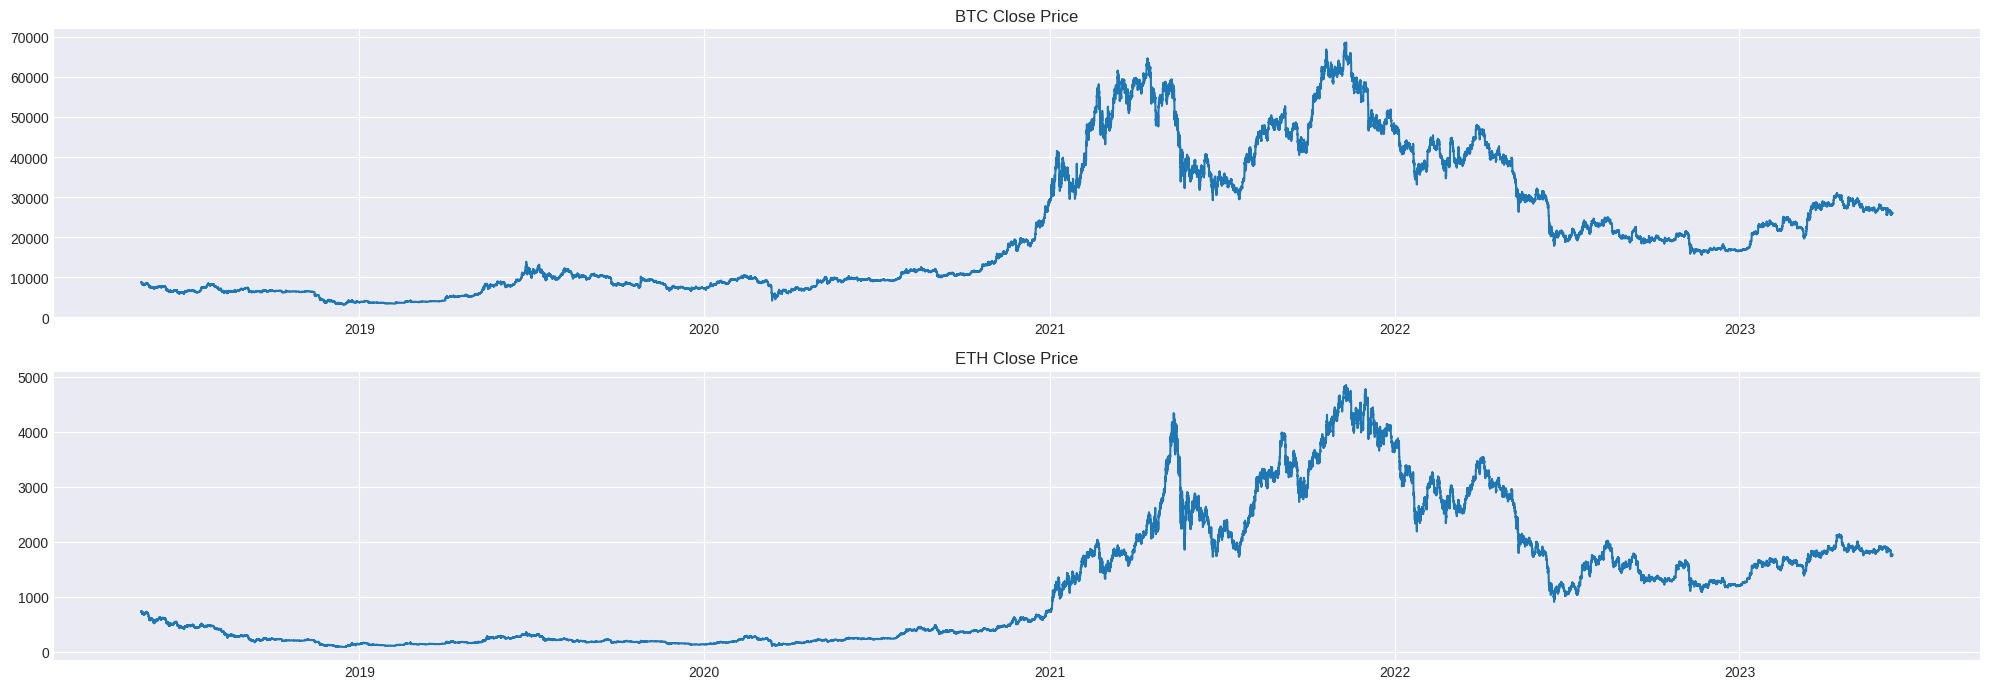

In [ ]:
# ploting the closing price
plt.figure(figsize=(20, 7))

# Plotting Bitcoin price
plt.subplot(2, 1, 1)
plt.plot(data_BTC["date"], data_BTC["close"])
plt.title("BTC Close Price")

# Plotting Ethereum price
plt.subplot(2, 1, 2)
plt.plot(data_ETH["date"], data_ETH["close"])
plt.title("ETH Close Price")

plt.tight_layout()
plt.show()

## Plot Lag Correlation

Lag plots are most commonly used to look for patterns in time series data. We will try to find hourly, daily, weekly and monthly correlations

Text(0.5, 1.0, 'Monthly Lag')

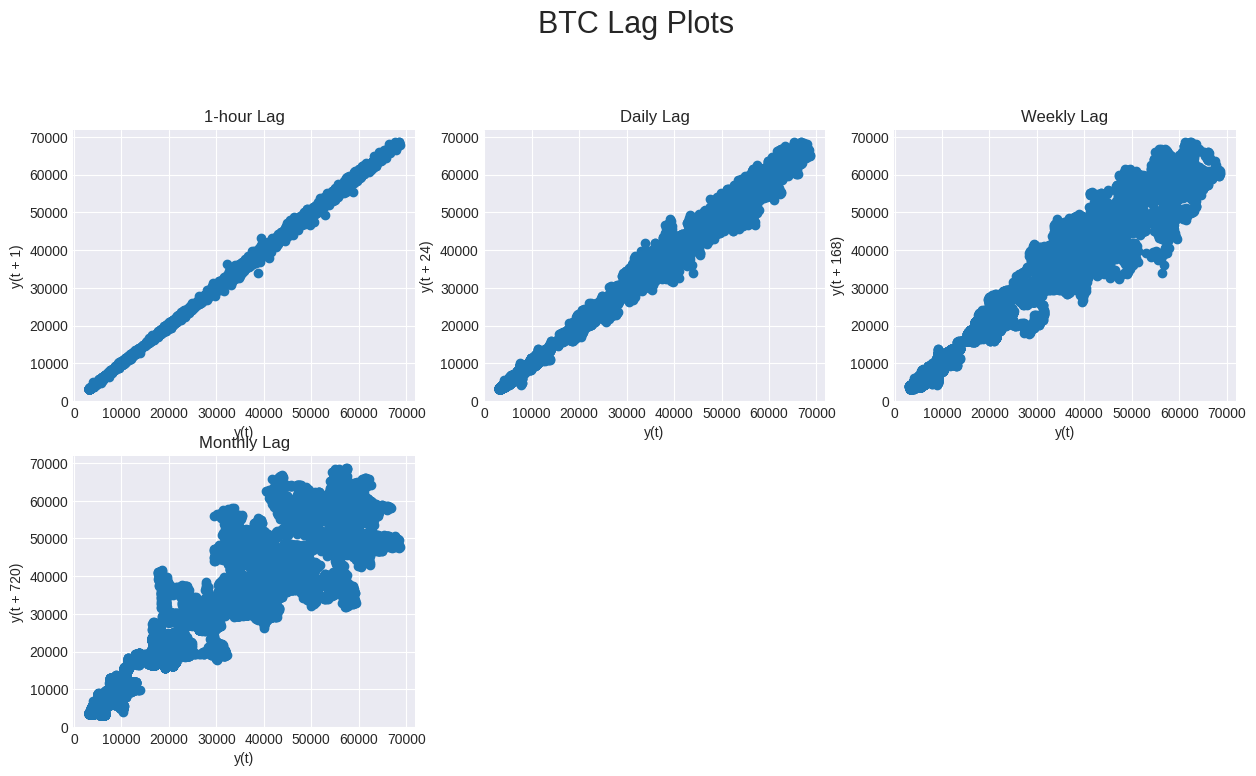

In [ ]:
# BTC lag plot
plt.figure(figsize=(15,12))
plt.suptitle('BTC Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(data_BTC["close"], lag=1) # hourly lag
plt.title('1-hour Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(data_BTC["close"], lag=24) # daily lag
plt.title('Daily Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(data_BTC["close"], lag=168) # weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(data_BTC["close"], lag=720) # Monthly lag
plt.title('Monthly Lag')

Text(0.5, 1.0, 'Monthly Lag')

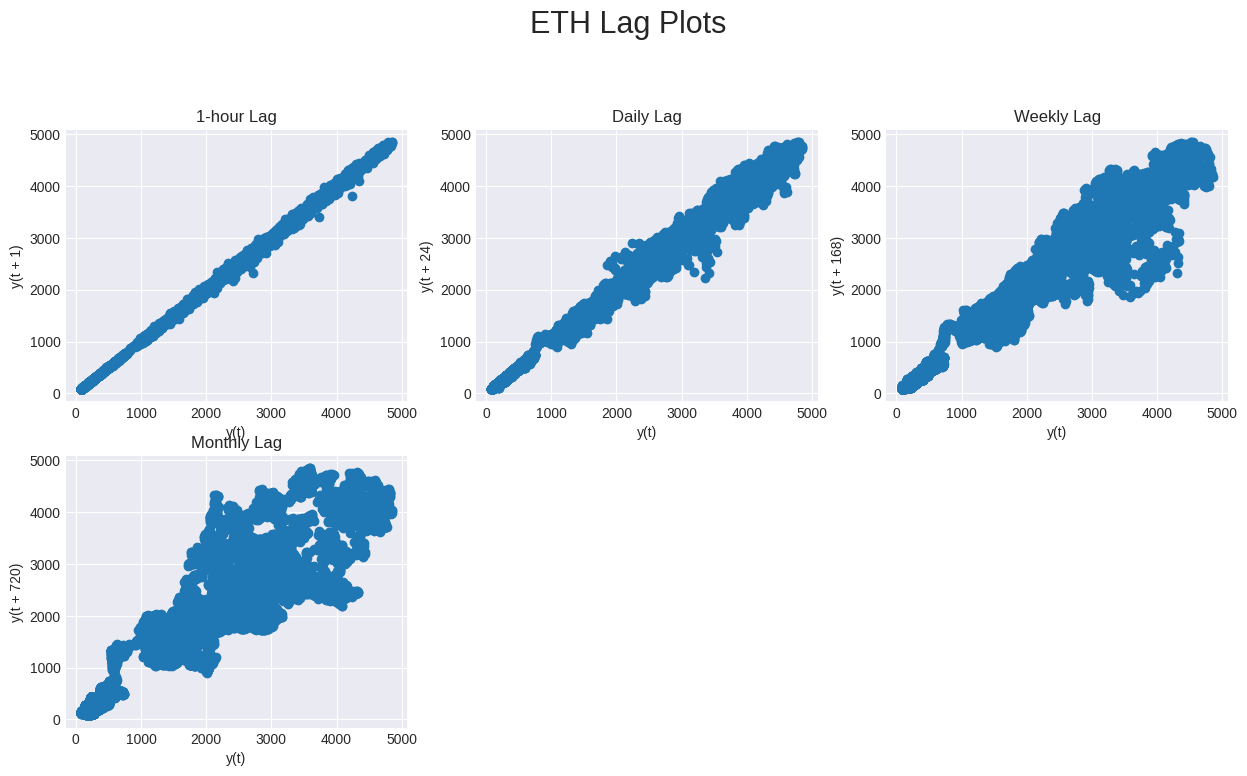

In [ ]:
# ETH lag plot

plt.figure(figsize=(15,12))
plt.suptitle('ETH Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(data_ETH["close"], lag=1) # hourly lag
plt.title('1-hour Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(data_ETH["close"], lag=24) # daily lag
plt.title('Daily Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(data_ETH["close"], lag=168) # weekly lag (24*7)
plt.title('Weekly Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(data_ETH["close"], lag=720) # Monthly lag (24*30)
plt.title('Monthly Lag')

We see that the hourly and daily lag is correlated but the weekly get some noise for both currencies. Therefore we can keep working with the daily lag

## Daily Resampling

Here we will resample based on the correlation using the resample method from pandas

In [ ]:
# BTC Daily resampling taking the mean value

data_BTC.set_index('date', inplace=True)  # Set 'date' column as the index

BTC_daily = data_BTC.resample('24H').mean()
BTC_daily = BTC_daily.reset_index()

BTC_daily.head()

,date,open,high,low,close
0,2018-05-15,8632.892222,8674.121667,8570.976111,8618.510556
1,2018-05-16,8279.441667,8340.754583,8232.085833,8274.091667
2,2018-05-17,8282.046250,8316.032917,8230.524167,8270.397917
3,2018-05-18,8098.805417,8144.327500,8065.463750,8106.382083
4,2018-05-19,8256.557500,8286.535833,8225.112083,8255.821250


In [ ]:
# ETH Daily resampling taking the mean value

data_ETH.set_index('date', inplace=True)  # Set 'date' column as the index

ETH_daily = data_ETH.resample('24H').mean()
ETH_daily = ETH_daily.reset_index()

ETH_daily.head()

,date,open,high,low,close
0,2018-05-15,722.480000,726.851667,716.320000,721.106667
1,2018-05-16,693.654583,699.620000,688.919167,693.633750
2,2018-05-17,698.945833,702.187083,693.633333,697.369167
3,2018-05-18,677.677917,681.943750,673.826250,678.657083
4,2018-05-19,696.186667,699.943333,692.697083,696.325833


### Daily Time Series

In [ ]:
# BTC Daily Time Series

fig = px.line(BTC_daily, x='date', y='close', title='BTC Close Price with Range Slider and Selectors')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")

        ])
    )
)

fig.show()

In [ ]:
# ETH Daily Time Series

fig = px.line(ETH_daily, x='date', y='close', title='ETH Close Price with Range Slider and Selectors')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")

        ])
    )
)

fig.show()

In [ ]:
# Plotting the BTC crash of Nov 2022

plot_ = BTC_daily.set_index("date").loc["2022-11"]

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['open'],
                    high=plot_['high'],
                    low=plot_['low'],
                    close=plot_['close']))

fig.update_layout(title="BTC November 2022")

fig.show()

In [ ]:
# Plotting the ETH crash of Nov 2022

plot_ = ETH_daily.set_index("date").loc["2022-11"]

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['open'],
                    high=plot_['high'],
                    low=plot_['low'],
                    close=plot_['close']))

fig.update_layout(title="ETH November 2022")

fig.show()

### Missing Data

In [ ]:
BTC_daily.isnull().sum()

date     0
open     0
high     0
low      0
close    0
dtype: int64

In [ ]:
ETH_daily.isnull().sum()

date     0
open     0
high     0
low      0
close    0
dtype: int64

## BTC Time Series Decomposition and Statistical Test

### Decomposition

<Figure size 1500x1200 with 0 Axes>

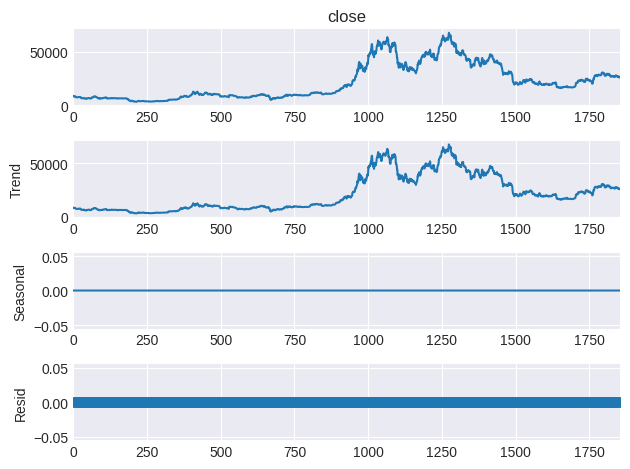

In [ ]:
# Additive Decomposition

plt.figure(figsize=(15,12))
series = BTC_daily.close
result = seasonal_decompose(series, model='additive',period=1)
result.plot();

# The plots show no seasonality and no variance over time (see plot seasonal). So this means we can use an ARIMA model as SARIMAX has seasonality

<Figure size 1500x1200 with 0 Axes>

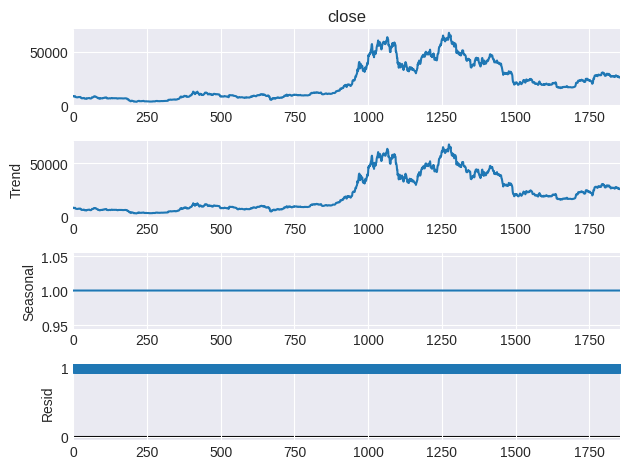

In [ ]:
# Multiplicative Decomposition

plt.figure(figsize=(15,12))

series = BTC_daily.close

result_mul = seasonal_decompose(series, model='multiplicative',period=1)
result_mul.plot();


The plots show no seasonality and no variance over time (see plot seasonal).

Residuals values are a around a mean with similar/no variance, so we need further to explore

### Autocorrelation: ACF and PACF

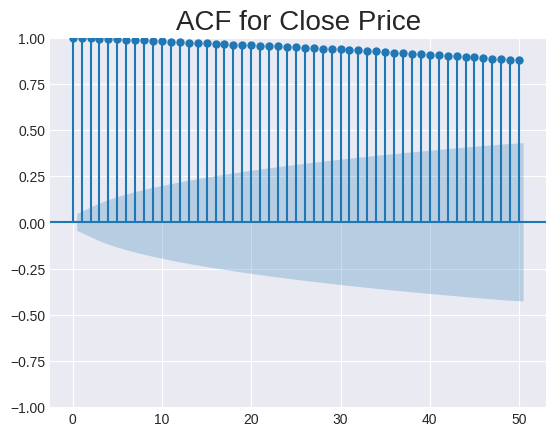

In [ ]:
# Plot each correlation in an autocorrelation graph (ACF) below. Correlation coefficients vs. Nr. lags

acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Close Price", size=20)
plt.show()

# All values outside the blue area are significant. It represents like in linear regression, the significance of the beta values
# Meaning the smaller the blue cone the better as we have more values outside and our confidence interval is higher

# Peak inside of cone ➔ not statistically significant. Not applicable in our case

# But we can add more lags as the more we have, the better our model will predict, as past values predict future values linearly in the ACF

Analysing the ACF for a specific time lag could be a good predictor for the current value...


...but only at face value!


ACF measures direct & indirect effects

This is why we must analyse each lag by isolation as well!
Using our linear modelling, we can isolate each lag term
This is known as Auto Regression (AR) and the analysis of lag terms is known as a **Partial Autocorrelation Function (PACF)**

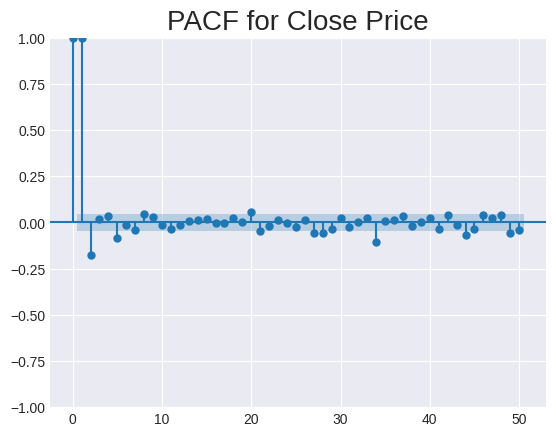

In [ ]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Close Price", size=20)
plt.show()

# Count the number of lags before the values drop below the confidence levels (blue)
#  Note that the first lag is ignored, as it represents / between and itself
# We see the number of lags is 2, as more than that is not statistically significant

### Stationarity

#### KPSS

In [ ]:
stats, p, lags, critical_values = kpss(series, 'ct')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [ ]:
print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

# If p-value is less than 0.05, then Test Statistics shall be higher than critical value 5%

Test Statistics : 0.7532315555002582
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


#### Augmented Dickey Fuller - ADF
ADF tests the following null hypothesis:

H0: The series is not-stationary

A p-value close to 0 (e.g. p < 0.05) indicates stationarity

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    p_value_adf = dftest[1]

    print("dftest: ", dftest)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value

    print (dfoutput)

    if p_value_adf > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [ ]:
adf_test(series)

Results of Dickey-Fuller Test:
dftest:  (-1.4584146553965496, 0.5539736437975203, 7, 1847, {'1%': -3.4338954312591943, '5%': -2.8631061094223527, '10%': -2.567603741659238}, 29790.07381547964)
Test Statistic                   -1.458415
p-value                           0.553974
#Lags Used                        7.000000
Number of Observations Used    1847.000000
Critical Value (1%)              -3.433895
Critical Value (5%)              -2.863106
Critical Value (10%)             -2.567604
dtype: float64
Series is not Stationary


The final result is that the series are **"Not Stationary"**

#### Differencing

Here we get non-stationary. So we need to do [differencing](https://https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) to make the series stationary

Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis cannot be rejected. Hence, the series is non stationary.

Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test.

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- Case 1: Both tests conclude that the series is not stationary - The series is
not stationary

- Case 2: Both tests conclude that the series is stationary - The series is stationary

- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

**Here is an example of the procedure to follow when we need to do differencing**

<Axes: >

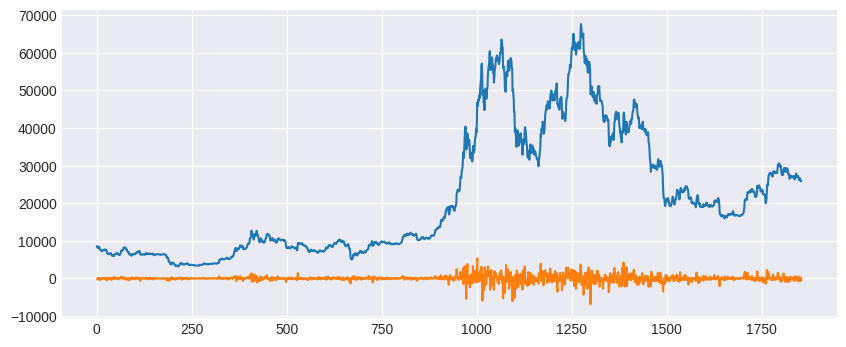

In [ ]:
# Adding 1 level of differencing
series_diff = series.diff(1)

series.plot(figsize=(10, 4))
series_diff.dropna().plot(figsize=(10, 4))

# We see now certain stationarity in the series_diff

In [ ]:
adf_test(series_diff.dropna())

Results of Dickey-Fuller Test:
dftest:  (-15.302818013705151, 4.289627240682544e-28, 6, 1847, {'1%': -3.4338954312591943, '5%': -2.8631061094223527, '10%': -2.567603741659238}, 29774.581608083114)
Test Statistic                -1.530282e+01
p-value                        4.289627e-28
#Lags Used                     6.000000e+00
Number of Observations Used    1.847000e+03
Critical Value (1%)           -3.433895e+00
Critical Value (5%)           -2.863106e+00
Critical Value (10%)          -2.567604e+00
dtype: float64
Series is Stationary


In [ ]:
stats_diff, p_diff, lags_diff, critical_values_diff = kpss(series_diff.dropna(), 'ct')

print(f'Test Statistics : {stats_diff}')
print(f'p-value : {p_diff}')
print(f'Critical Values : {critical_values_diff}')

if p_diff < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 0.09728159931778635
p-value : 0.1
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is Stationary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




**ADF and KPPS are now stationary with one level of differencing (d = 1)**

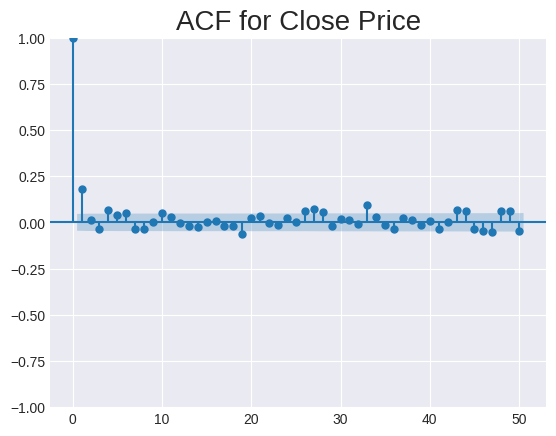

In [ ]:
# ACF for d = 1
acf = plot_acf(series_diff.dropna(), lags=50, alpha=0.05)
plt.title("ACF for Close Price", size=20)
plt.show()

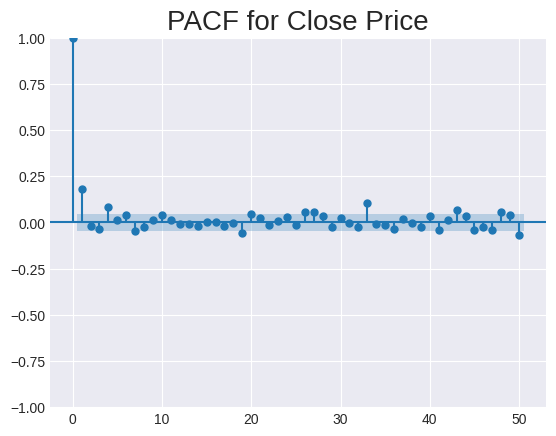

In [ ]:
# PACF for d = 1
plot_pacf(series_diff.dropna(), lags=50, alpha=0.05, method='ols')
plt.title("PACF for Close Price", size=20)
plt.show()

We use the PACF plot to calculate the value for **p = 1** (nr of lags, excluding the first, till it drops into the blue area)
We use the ACF plot to calculate the value for **q = 1** (nr of lags, excluding the first, till it drops into the blue area)

This means we can use an ARIMA model (1,1,1), but we can also calculate p,q and d using `ndiffs` or `pm.auto_arima` automatically

In [ ]:
# Automatically estimate differencing term

ndiffs(series)

1

In [ ]:
# Automatically estimate p,d,q terms

smodel = pm.auto_arima(series,
          start_p=0, max_p=2,
          start_q=0, max_q=2,
          trend='t',
          seasonal=False,
          trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30243.610, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30187.004, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30187.601, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30243.610, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30188.337, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30188.551, Time=1.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30190.110, Time=2.67 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30187.004, Time=0.67 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 6.524 seconds


Here ARIMA has calculated (1,1,0).

Several models have similar AIC values around 30188 and our previous estimation is also good

Any of them might be the "true" underlying process

👉 When in doubt, pick the simplest model. In this case (1,1,0) is simpler

## ETH Time Series Decomposition and Statistical Test

### Decomposition

<Figure size 1500x1200 with 0 Axes>

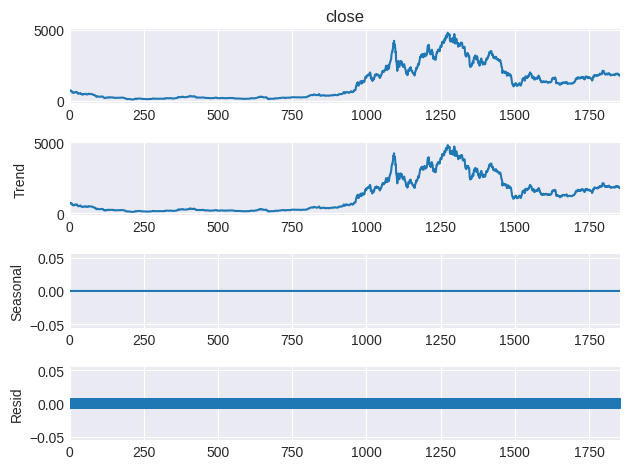

In [ ]:
# Additive Decomposition

plt.figure(figsize=(15,12))

series = ETH_daily.close

result = seasonal_decompose(series, model='additive',period=1)
result.plot();

# The plots show no seasonality and no variance over time (see plot seasonal). So this means we can use an ARIMA model as SARIMAX has seasonality

<Figure size 1500x1200 with 0 Axes>

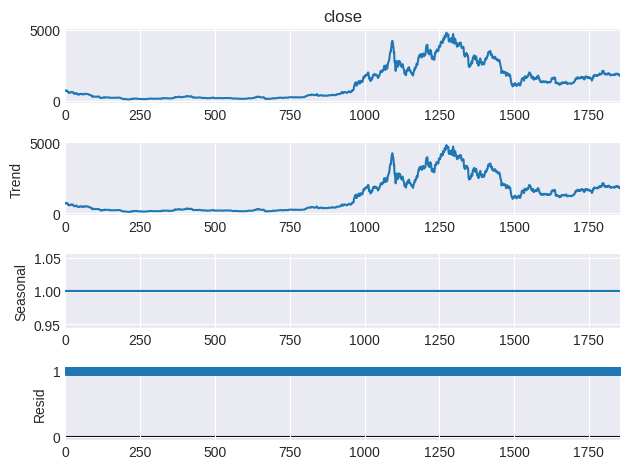

In [ ]:
# Multiplicative Decomposition

plt.figure(figsize=(15,12))

series = ETH_daily.close
result_mul = seasonal_decompose(series, model='multiplicative',period=1)

result_mul.plot();

# The plots show no seasonality and no variance over time (see plot seasonal). So this means it is non-stationary

The plots show no seasonality and no variance over time (see plot seasonal).

Residuals values are a around a mean with similar/no variance, so we need further to explore

### Autocorrelation: ACF and PACF

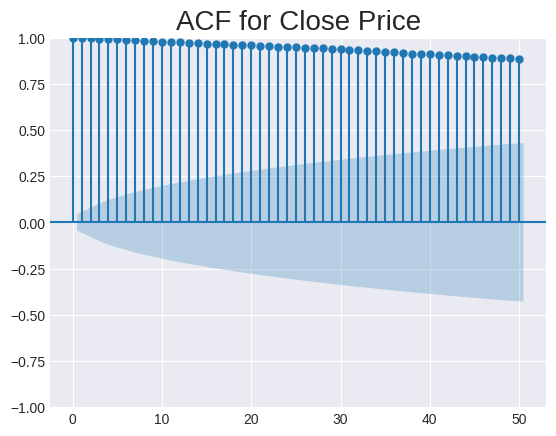

In [ ]:
# Plot each correlation in an autocorrelation graph (ACF) below. Correlation coefficients vs. Nr. lags

acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Close Price", size=20)
plt.show()

# All values outside the blue area are significant. It represents like in linear regression, the significance of the beta values
# Meaning the smaller the blue cone the better as we have more values outside and our confidence interval is higher

# Peak inside of cone ➔ not statistically significant. Not applicable in our case

# But we can add more lags as the more we have, the better our model will predict, as past values predict future values linearly in the ACF

Analysing the ACF for a specific time lag could be a good predictor for the current value...


...but only at face value!


ACF measures direct & indirect effects

This is why we must analyse each lag by isolation as well!
Using our linear modelling, we can isolate each lag term
This is known as Auto Regression (AR) and the analysis of lag terms is known as a **Partial Autocorrelation Function (PACF)**

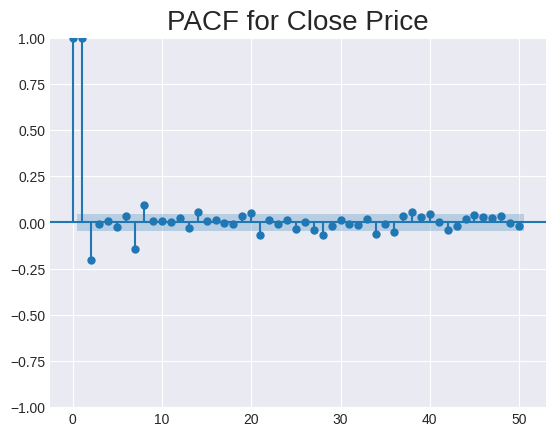

In [ ]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Close Price", size=20)
plt.show()

# Count the number of lags before the values drop below the confidence levels (blue)
#  Note that the first lag is ignored, as it represents / between and itself
# We see the number of lags is 2, as more than that is not statistically significant

### Stationarity

#### KPSS

In [ ]:
stats, p, lags, critical_values = kpss(series, 'ct')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [ ]:
print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

# If p-value is less than 0.05, then Test Statistics shall be higher than critical value 5%

Test Statistics : 0.6347797730353009
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


#### Augmented Dickey Fuller - ADF
ADF tests the following null hypothesis:

H0: The series is not-stationary

A p-value close to 0 (e.g. p < 0.05) indicates stationarity

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    p_value_adf = dftest[1]

    print("dftest: ", dftest)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value

    print (dfoutput)

    if p_value_adf > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [ ]:
adf_test(series)

Results of Dickey-Fuller Test:
dftest:  (-1.4446916767116704, 0.5606729085403456, 7, 1847, {'1%': -3.4338954312591943, '5%': -2.8631061094223527, '10%': -2.567603741659238}, 20233.492676468406)
Test Statistic                   -1.444692
p-value                           0.560673
#Lags Used                        7.000000
Number of Observations Used    1847.000000
Critical Value (1%)              -3.433895
Critical Value (5%)              -2.863106
Critical Value (10%)             -2.567604
dtype: float64
Series is not Stationary


The final result is that the series are **"Not Stationary"**

#### Differencing

Here we get non-stationary. So we need to do [differencing](https://https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) to make the series stationary

Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis cannot be rejected. Hence, the series is non stationary.

Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test.

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- Case 1: Both tests conclude that the series is not stationary - The series is
not stationary

- Case 2: Both tests conclude that the series is stationary - The series is stationary

- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

**Here is an example of the procedure to follow when we need to do differencing**

<Axes: >

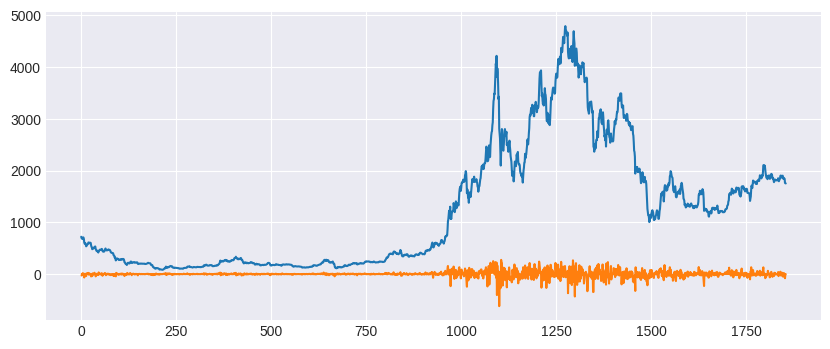

In [ ]:
# Adding 1 level of differencing
series_diff = series.diff(1)

series.plot(figsize=(10, 4))
series_diff.dropna().plot(figsize=(10, 4))

# We see now certain stationarity in the series_diff

In [ ]:
adf_test(series_diff.dropna())

Results of Dickey-Fuller Test:
dftest:  (-15.370894262877783, 3.5096912602092503e-28, 6, 1847, {'1%': -3.4338954312591943, '5%': -2.8631061094223527, '10%': -2.567603741659238}, 20223.04859501755)
Test Statistic                -1.537089e+01
p-value                        3.509691e-28
#Lags Used                     6.000000e+00
Number of Observations Used    1.847000e+03
Critical Value (1%)           -3.433895e+00
Critical Value (5%)           -2.863106e+00
Critical Value (10%)          -2.567604e+00
dtype: float64
Series is Stationary


In [ ]:
stats_diff, p_diff, lags_diff, critical_values_diff = kpss(series_diff.dropna(), 'ct')

print(f'Test Statistics : {stats_diff}')
print(f'p-value : {p_diff}')
print(f'Critical Values : {critical_values_diff}')

if p_diff < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 0.09630872388577445
p-value : 0.1
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is Stationary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




**ADF and KPPS are now stationary with one level of differencing (d = 1)**

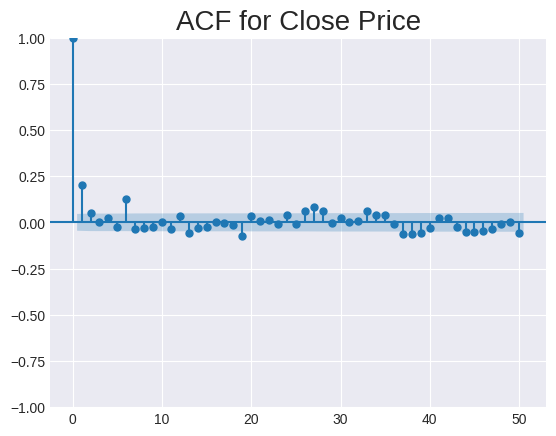

In [ ]:
# ACF for d = 1
acf = plot_acf(series_diff.dropna(), lags=50, alpha=0.05)
plt.title("ACF for Close Price", size=20)
plt.show()

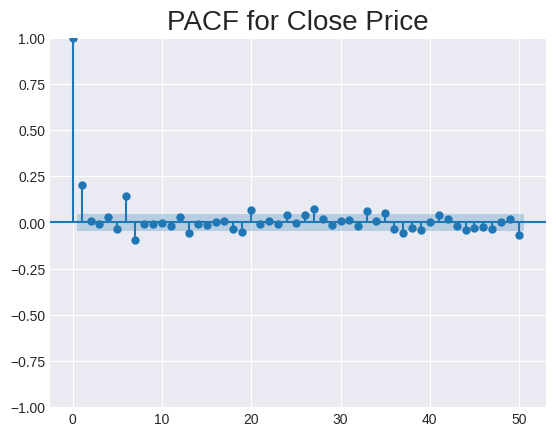

In [ ]:
# PACF for d = 1
plot_pacf(series_diff.dropna(), lags=50, alpha=0.05, method='ols')
plt.title("PACF for Close Price", size=20)
plt.show()

We use the PACF plot to calculate the value for **p = 1** (nr of lags, excluding the first, till it drops into the blue area)
We use the ACF plot to calculate the value for **q = 1** (nr of lags, excluding the first, till it drops into the blue area)

This means we can use an ARIMA model (1,1,1), but we can also calculate p,q and d using pm.auto_arima automatically

In [ ]:
# Automatically estimate differencing term

ndiffs(series)

1

In [ ]:
# Automatically estimate p,d,q terms

smodel = pm.auto_arima(series,
          start_p=0, max_p=2,
          start_q=0, max_q=2,
          trend='t',
          seasonal=False,
          trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20612.904, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20535.846, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20540.456, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20612.904, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20537.734, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20537.745, Time=2.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20539.698, Time=2.55 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20535.846, Time=0.51 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 8.814 seconds


Here ARIMA has calculated (1,1,0).

Several models have similar AIC values around 20537 and our previous estimation is also good

Any of them might be the "true" underlying process

👉 When in doubt, pick the simplest model. In this case (1,1,0) is simpler

## BTC Trends: Moving Average

Rolling or moving average is a method to average out noise, which are random short-term fluctuations in price, from data and make easier to detect trends. Splits and aggregating the data into windows accorging to functions like mean, median...

For example, a 7-day moving average reflects short-term trends in the stock market, whereas a 100-day rolling average indicates major trends in the stock market.

Here we calculate the **arithmetic mean** of a given set of prices over a specified period.

In [ ]:
BTC_daily = BTC_daily.set_index('date')

# compute a short-term 20-day moving average
MA20 = BTC_daily.close.rolling(20).mean()

# compute a Long-term 50-day moving average
MA50 = BTC_daily.close.rolling(50).mean()

# compute a Long-term 100-day moving average
MA100 = BTC_daily.close.rolling(100).mean()

In [ ]:
# Create a trace for the closing price
trace_close = go.Scatter(x=BTC_daily.index, y=BTC_daily.close, mode='lines', name='Closing')

# Create traces for the moving averages
trace_ma100 = go.Scatter(x=BTC_daily.index, y=MA100, mode='lines', name='MA100', line=dict(color='red'))
trace_ma50 = go.Scatter(x=BTC_daily.index, y=MA50, mode='lines', name='MA50', line=dict(color='green'))
trace_ma20 = go.Scatter(x=BTC_daily.index, y=MA20, mode='lines', name='MA20', line=dict(color='orange'))


layout = go.Layout(
    title='BTC Moving Averages',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    showlegend=True,
    height = 800,
    width=1800  # Adjust the width as per your preference
)

# Create a figure and add the traces and layout
fig = go.Figure(data=[trace_close, trace_ma100, trace_ma50, trace_ma20], layout=layout)

# Show the plot
fig.show()


We can observe from the chart that in May of 2021, the price crosses below the 50-day MA, which indicates a **downward trend**, and in August 2021, the price crosses above the MA, which shows an **upward trend**.

From the charts that around May of 2021, the 20-day MA crosses below the 100-day MA. It indicates that the trend is shifting downwards, and **it’s a sell signal**. Towards August 2021, the 20-day MA crosses above the 100-day MA. It shows that the trend is shifting upwards, and it’s a **buy signal**.

Further investigating the charts in detail during 2021 or 2022 separately, which are the years with more fluctuations, can bring interesting insights

## ETH Trends: Moving Average

Rolling or moving average is a method to average out noise, which are random short-term fluctuations in price, from data and make easier to detect trends. Splits and aggregating the data into windows accorging to functions like mean, median...

For example, a 7-day moving average reflects short-term trends in the stock market, whereas a 100-day rolling average indicates major trends in the stock market.

Here we calculate the **arithmetic mean** of a given set of prices over a specified period.

In [ ]:
ETH_daily = ETH_daily.set_index('date')

# compute a short-term 20-day moving average
MA20 = ETH_daily.close.rolling(20).mean()

# compute a Long-term 50-day moving average
MA50 = ETH_daily.close.rolling(50).mean()

# compute a Long-term 100-day moving average
MA100 = ETH_daily.close.rolling(100).mean()

In [ ]:
# Create a trace for the closing price
trace_close = go.Scatter(x=ETH_daily.index, y=ETH_daily.close, mode='lines', name='Closing')

# Create traces for the moving averages
trace_ma100 = go.Scatter(x=ETH_daily.index, y=MA100, mode='lines', name='MA100', line=dict(color='red'))
trace_ma50 = go.Scatter(x=ETH_daily.index, y=MA50, mode='lines', name='MA50', line=dict(color='green'))
trace_ma20 = go.Scatter(x=ETH_daily.index, y=MA20, mode='lines', name='MA20', line=dict(color='orange'))

layout = go.Layout(
    title='ETH Moving Averages',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    showlegend=True,
    height = 800,
    width=1800  # Adjust the width as per your preference
)

# Create a figure and add the traces and layout
fig = go.Figure(data=[trace_close, trace_ma100, trace_ma50, trace_ma20], layout=layout)

# Show the plot
fig.show()


We can observe from the chart that in May of 2021, the price crosses below the 50-day MA, which indicates a **downward trend**, and in August 2021, the price crosses above the MA, which shows an **upward trend**.

From the charts that around May of 2021, the 20-day MA crosses below the 100-day MA. It indicates that the trend is shifting downwards, and **it’s a sell signal**. Towards August 2021, the 20-day MA crosses above the 100-day MA. It shows that the trend is shifting upwards, and it’s a **buy signal**.

Further investigating the charts in detail during 2021 or 2022 separately, which are the years with more fluctuations, can bring interesting insights

## Daily Return Series

A return, also known as a financial return, in its simplest terms, is the money made or lost on an investment over some period of time.

A return is a change in the price of an asset over time.

Returns can be positive, representing a profit, or negative, indicating a loss. Return series of an asset are easier to handle than price series and give a complete summary of the investment opportunity.

We will use the pandas **`pct_change()`** function to compute the returns.

These are relative price changes of the cryptocurrencies

In [ ]:
close_BTC = BTC_daily[["close"]]
close_BTC.head()

,close
date,
2018-05-15,8618.510556
2018-05-16,8274.091667
2018-05-17,8270.397917
2018-05-18,8106.382083
2018-05-19,8255.821250


In [ ]:
close_ETH = ETH_daily[["close"]]
close_ETH.head()

,close
date,
2018-05-15,721.106667
2018-05-16,693.633750
2018-05-17,697.369167
2018-05-18,678.657083
2018-05-19,696.325833


In [ ]:
# Returns i.e. percentage change in the adjusted close price and drop the first row with NA's

returns_BTC = close_BTC.pct_change().dropna(axis=0)
returns_ETH = close_ETH.pct_change().dropna(axis=0)

In [ ]:
returns_BTC.head()

,close
date,
2018-05-16,-0.039963
2018-05-17,-0.000446
2018-05-18,-0.019832
2018-05-19,0.018435
2018-05-20,0.013150


In [ ]:
returns_ETH.head()

,close
date,
2018-05-16,-0.038098
2018-05-17,0.005385
2018-05-18,-0.026832
2018-05-19,0.026035
2018-05-20,0.020387


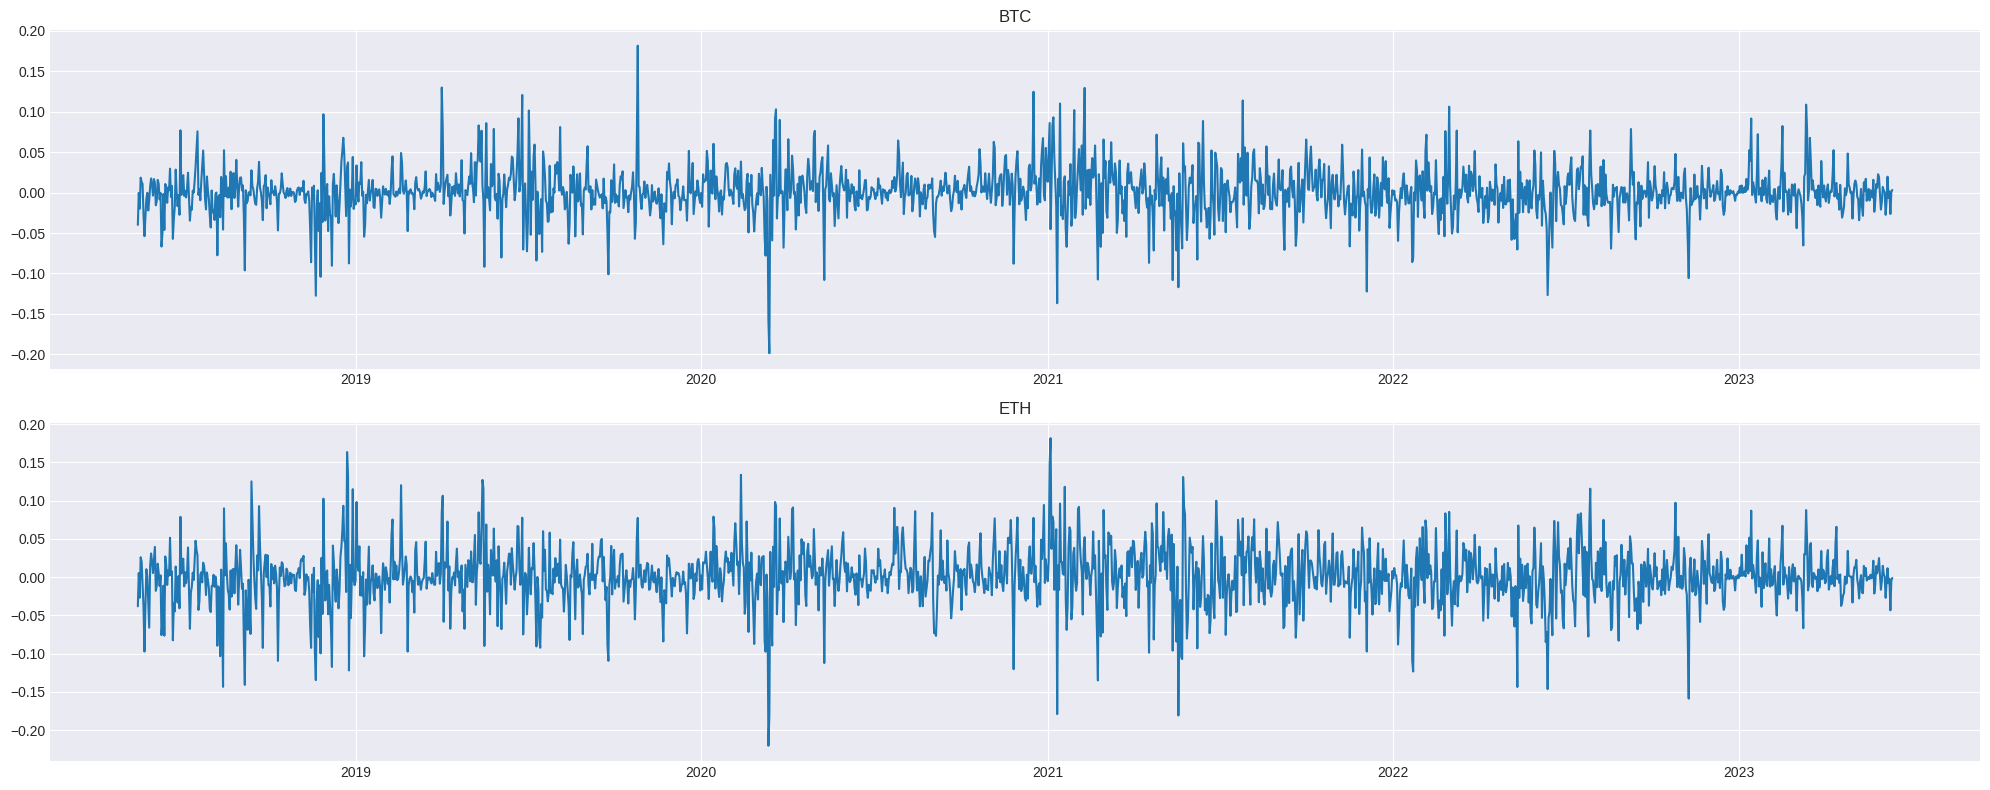

In [ ]:
# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 8))

# Plotting Bitcoin adjusted closing price
axs[0].plot(returns_BTC.index, returns_BTC.close)
axs[0].set_title('BTC')

# Plotting Ethereum adjusted closing price
axs[1].plot(returns_ETH.index, returns_ETH.close)
axs[1].set_title('ETH')

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()


For bothcryptocurrencies, we can see a huge crash around March of 2020 and also another crash in November 2022 after the crypto exchange FTX collapsed

### Volatilty

Volatility is a measure of change in the price of an asset over time. The higher the standard deviation, the more volatile an asset is.

In [ ]:
# Volatility, standard deviation of the returns

returns_BTC.std(), returns_ETH.std()

(close    0.029648
 dtype: float64,
 close    0.037805
 dtype: float64)

ETH is more volatile than Bitcoin

### Cumulative Returns

Cumulative return express the total change in the price of an asset over time.

We use the pandas **`cumprod()`** function to calculate the daily cumulative simple returns.

In [ ]:
# Cumulative return series

cum_returns_BTC = ((1 + returns_BTC).cumprod() - 1)*100
cum_returns_BTC.head()

,close
date,
2018-05-16,-3.996269
2018-05-17,-4.039128
2018-05-18,-5.942192
2018-05-19,-4.208260
2018-05-20,-2.948616


In [ ]:
# Cumulative return series

cum_returns_ETH = ((1 + returns_ETH).cumprod() - 1)*100
cum_returns_ETH.head()

,close
date,
2018-05-16,-3.809827
2018-05-17,-3.291815
2018-05-18,-5.886727
2018-05-19,-3.436500
2018-05-20,-1.467883


In [ ]:
# Plot the cumulative returns for Bitcoin
fig = px.line(cum_returns_BTC.close, title='Cumulative Returns - BTC & ETH')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Cumulative Returns')

# Add the cumulative returns for Ethereum to the existing figure
fig.add_scatter(x=cum_returns_ETH.index, y=cum_returns_ETH.close, name='Ethereum', line=dict(color='red'))

# Display the plot
fig.show()




Both currencies show a similar behaviour, but BTC overcomes ETH

### Correlation

Correlation is the degree in which asset prices move together (positive correlation) or against each other (negative correlation). The exact measurement is referred to as the correlation coefficient and always falls between a negative and positive spectrum of -1.0 to +1.0. Coefficients close to zero indicate no correlation.

We’ll show the correlation on returns since correlation on raw price data can give biased results.

For than we join the dataframes of both currencies and plot a heatmap

In [ ]:
returns_BTC = returns_BTC.rename(columns={"close": "close_BTC"})
returns_BTC.head()

,close_BTC
date,
2018-05-16,-0.039963
2018-05-17,-0.000446
2018-05-18,-0.019832
2018-05-19,0.018435
2018-05-20,0.013150


In [ ]:
returns_ETH = returns_ETH.rename(columns={"close": "close_ETH"})
returns_ETH.head()

,close_ETH
date,
2018-05-16,-0.038098
2018-05-17,0.005385
2018-05-18,-0.026832
2018-05-19,0.026035
2018-05-20,0.020387


In [ ]:
joined_df = pd.merge(returns_BTC, returns_ETH, left_index=True, right_index=True)
joined_df.head()

,close_BTC,close_ETH
date,,
2018-05-16,-0.039963,-0.038098
2018-05-17,-0.000446,0.005385
2018-05-18,-0.019832,-0.026832
2018-05-19,0.018435,0.026035
2018-05-20,0.013150,0.020387


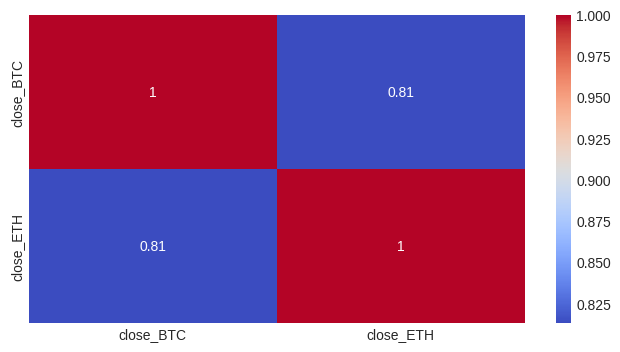

In [ ]:
#plot the correlations
plt.figure(figsize=(8,4))

sns.heatmap(joined_df.corr(), annot=True, cmap='coolwarm')
plt.show()

From the heatmap, we can see that BTC and ETH, are highly correlated.

That means for example that when BTC goes up, ETH also goes up, and when BTC falls, ETH also falls.